## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def show_gray_image(image, title=''):
    # image is [H, W]
    # assert image.shape[2] == 1
    plt.imshow(torch.clip((image * (0.299*0.299+0.587*0.224+0.114*0.225) + 0.299*0.485+0.587*0.456+0.114*0.406) * 255, 0, 255).int(), cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(ori_img, gray_img, model):
    x = torch.tensor(gray_img, dtype=torch.float32)
    ori_img = torch.tensor(ori_img, dtype=torch.float32)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = x.unsqueeze(dim=3)
    x = torch.einsum('nhwc->nchw', x)
    # run MAE
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.0)
    y = model.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
    # loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = ori_img * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_gray_image(x[0], "input")

    plt.subplot(1, 4, 2)
    show_gray_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

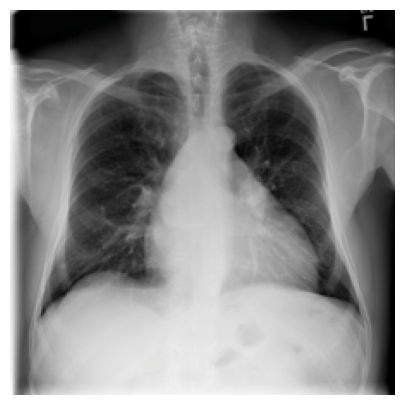

In [3]:
from torchvision import transforms
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
ori_img = Image.open('../data/images/00000001_000.png').convert ('RGB')
gray_transform = transforms.Grayscale(num_output_channels=1)
gray_img = gray_transform(ori_img)
gray_img = gray_img.resize((224, 224))
gray_img = np.array(gray_img)
gray_img = gray_img / 255.
gray_img = gray_img - (0.299*0.485+0.587*0.456+0.114*0.406)
gray_img = gray_img / (0.299*0.299+0.587*0.224+0.114*0.225)

ori_img = ori_img.resize((224,224))
ori_img = np.array(ori_img) / 255.
# assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
ori_img = ori_img - imagenet_mean
ori_img = ori_img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(ori_img))

### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '../pretrained_ckpt/checkpoint-799.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


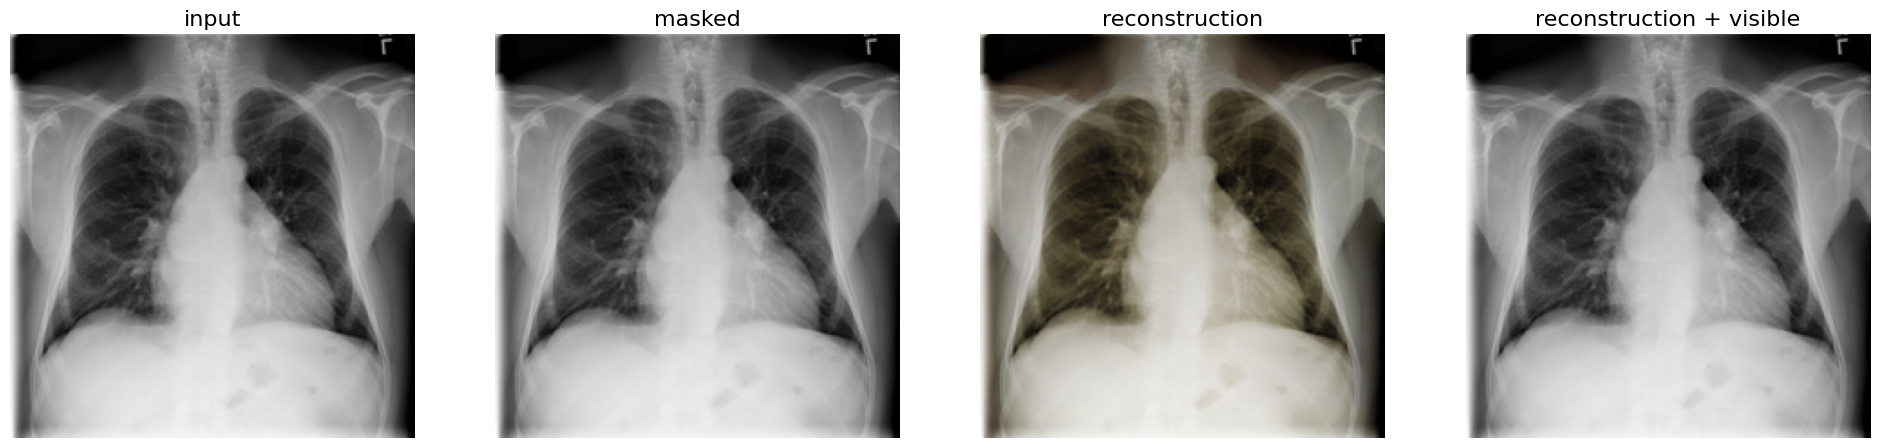

In [5]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(ori_img, gray_img, model_mae)